In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse, schedule

from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional, Union

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_72531/2268176252.py:19: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_hanoi') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_algiers') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQBackend('ibm_cairo') from IBMQ(hub='ibm-q-nus', group='default', project='default')>,
 <IBMQ

In [3]:
DEBUG_PRINT = False

backend = provider.get_backend('ibm_cairo') # replace the name with the exact one for the backend that is desired from the previous displayed backends
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

qubit = qubit_0

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

In [4]:
from helper_funcs.utils import *

tau_1_est = 45 * ns
tau_1_span = 14 * ns
num_tau_1 = 5

tau_1_linspace = np.linspace(-0.5 * tau_1_span + tau_1_est, 0.5 * tau_1_span + tau_1_est, num_tau_1)
real_tau_1_linspace = convert_arr_to_dt(tau_1_linspace)

print(tau_1_linspace/ns)
print(real_tau_1_linspace/ns)

[38.  41.5 45.  48.5 52. ]
[39.11111111 42.66666667 46.22222222 49.77777778 53.33333333]


In [5]:
tau_readout = get_dt_from(270 * ns) * dt
tau_3 = get_dt_from(45 * ns) * dt
print(tau_readout/ns)
print(tau_3/ns)

w

270.22222222222223
46.222222222222214
[7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111 3.55555556
 7.11111111 3.55555556 7.11111111 3.55555556 7.11111111]
[149.33333333 156.44444444 160.         167.11111111 170.66666667
 177.77777778 181.33333333 188.44444444 192.         199.11111111
 202.66666667 209.77777778 213.33333333 220.44444444 224.
 231.11111111 234.66666667 241.77777778 245.33333333 252.44444444
 256.         263.11111111 266.66666667 273.77777778 277.33333333
 284.44444444 288.         295.11111111 298.66666667 305.77777778
 309.33333333 316.44444444 320.         327.1111

576


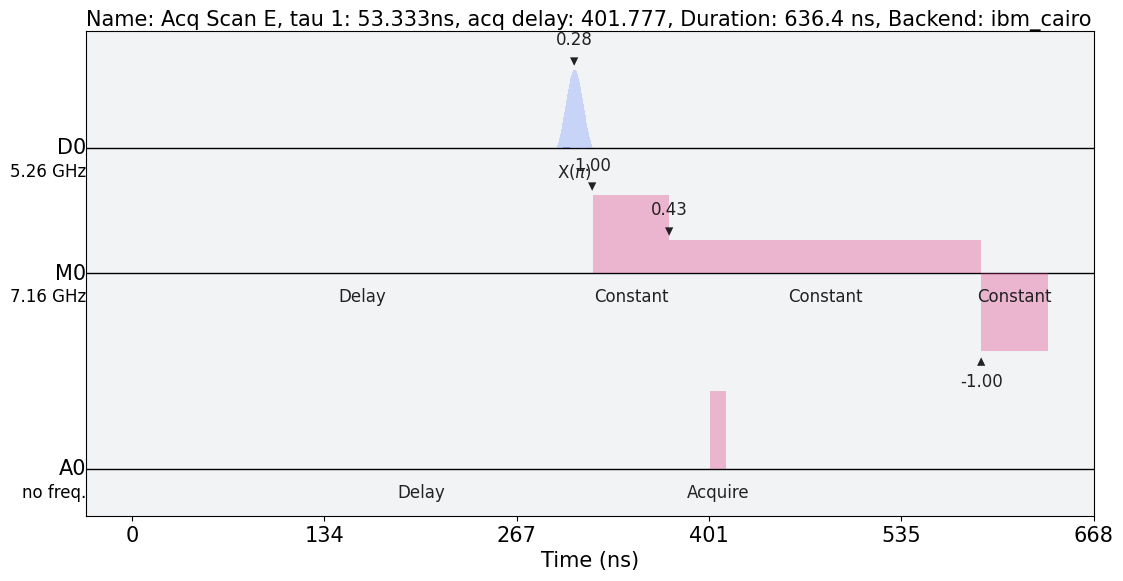

In [6]:
total_exp_g = []
total_exp_e = []

for tau_1 in real_tau_1_linspace:
    tau_1_dt = get_dt_from(tau_1)

    for acq_delay_sec in real_acq_linspace:
        acq_delay_dt = get_dt_from(acq_delay_sec)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Acq Scan G, tau 1: {int(1e3*tau_1_dt*dt/ns)/1e3}ns, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}'
        ) as acq_sched_g:
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            pulse.delay(acq_latency_dt, meas_chan)
            
            pulse.play(
                pulse.Constant(duration=tau_1_dt, amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_readout - tau_1_dt * dt), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_3), amp=-1.0),
                meas_chan
            )
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration_dt,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        total_exp_g.append(acq_sched_g)

        with pulse.build(
            backend=backend,
            default_alignment='left',
            name=f'Acq Scan E, tau 1: {int(1e3*tau_1_dt*dt/ns)/1e3}ns, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}'
        ) as acq_sched_e:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)
            acq_chan = pulse.acquire_channel(qubit)

            with pulse.align_right():
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(acq_latency_dt, meas_chan)
            
            pulse.play(
                pulse.Constant(duration=tau_1_dt, amp=1.0),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_readout - tau_1_dt * dt), amp=measure_pulse.amp),
                meas_chan
            )
            pulse.play(
                pulse.Constant(duration=get_dt_from(tau_3), amp=-1.0),
                meas_chan
            )
            pulse.delay(acq_delay_dt, acq_chan)
            pulse.acquire(
                duration=acq_duration_dt,
                qubit_or_channel=acq_chan,
                register=pulse.MemorySlot(qubit)
            )
        total_exp_e.append(acq_sched_e)

for acq_delay_sec in real_acq_linspace:
    acq_delay_dt = get_dt_from(acq_delay_sec)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Normal Acq Scan G, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}'
    ) as normal_acq_sched_g:
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        pulse.delay(acq_latency_dt, meas_chan)
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    total_exp_g.append(normal_acq_sched_g)

    with pulse.build(
        backend=backend,
        default_alignment='left',
        name=f'Normal Acq Scan E, acq delay: {int(1e3*acq_delay_dt*dt/ns)/1e3}'
    ) as normal_acq_sched_e:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)
        acq_chan = pulse.acquire_channel(qubit)

        with pulse.align_right():
            pulse.play(x_pulse, qubit_chan)
            pulse.delay(acq_latency_dt, meas_chan)
        
        pulse.play(measure_pulse, meas_chan)
        pulse.delay(acq_delay_dt, acq_chan)
        pulse.acquire(
            duration=acq_duration_dt,
            qubit_or_channel=acq_chan,
            register=pulse.MemorySlot(qubit)
        )
    total_exp_e.append(normal_acq_sched_e)

total_exp = total_exp_g + total_exp_e
print(len(total_exp))

total_exp_e[-49].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True
)

In [7]:
acquisition_checker(total_exp)

num_shots = 4096
rep_delay = 499.0 * 1e-6

In [8]:
job_1 = provider.backend.retrieve_job('cpcn0a9prheg008rvnng')
job_2 = provider.backend.retrieve_job('cpcn0hj2zy6g008nz250')

In [9]:
result_1 = get_results_arr(job_1.result(), qubit)
result_2 = get_results_arr(job_2.result(), qubit)

In [10]:
result_g = result_1
result_e = result_2

[[-2.91135406 -2.1249435  -1.33445843 -0.551181    0.23726978 -2.12377036
  -1.33229838 -3.69597044 -2.9055179  -2.11745077 -1.33314276 -0.54426926
   0.25515158 -2.09873525 -1.30979459 -3.6565766  -2.86492365 -2.06768044
  -1.27621916 -0.48366211  0.31406501 -2.03577457 -1.24700413 -3.59073125
  -2.80147294 -2.00673565 -1.21850412 -0.41961099  0.371449   -1.98042861
  -1.1875387  -3.53582442 -2.74325924 -1.96207229 -1.16842478 -0.36953701
   0.41743807 -1.93273423 -1.14427992 -3.49327486 -2.70615475 -1.91766512
  -1.12368152 -0.33081857  0.46076523 -1.89044471 -1.10274842 -3.45151396]
 [-3.41302114 -2.62880323 -1.85404184 -1.07526575 -0.29462699  0.48676419
  -1.87312438 -1.09641711 -3.4620975  -2.68079939 -1.89373659 -1.10870727
  -0.31696609  0.46251511 -1.89286358 -1.10072778 -3.45259129 -2.66058885
  -1.87276833 -1.07913136 -0.28996019  0.50440665 -1.85274929 -1.05965431
  -3.41316287 -2.6246672  -1.83270028 -1.04378512 -0.25163602  0.53456958
  -1.81329836 -1.02454116 -3.37962005

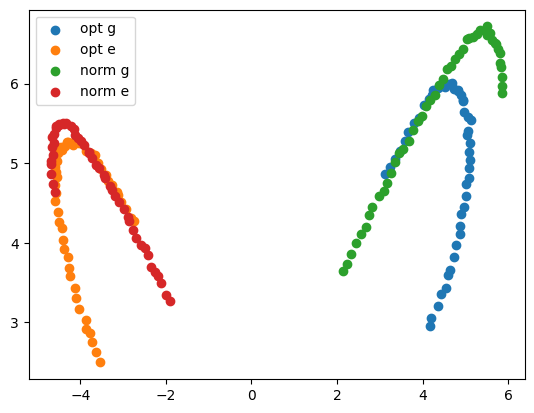

In [20]:
mean_g = np.mean(result_g, axis=-1).reshape(num_tau_1 + 1, -1)
mean_e = np.mean(result_e, axis=-1).reshape(num_tau_1 + 1, -1)

angle_dev = 0.5 * (np.angle(mean_g) + np.angle(mean_e)) - 0.5 * np.pi
# angle_dev = angle_dev % (2 * np.pi)
print(angle_dev)

mean_g *= np.exp(-1.0j * angle_dev)
mean_e *= np.exp(-1.0j * angle_dev)

mean_g *= np.sign(mean_g.imag)
mean_e *= np.sign(mean_e.imag)

opt_ind = 2
norm_ind = -1

plt.scatter(mean_g[opt_ind].real, mean_g[opt_ind].imag, label='opt g')
plt.scatter(mean_e[opt_ind].real, mean_e[opt_ind].imag, label='opt e')
plt.scatter(mean_g[norm_ind].real, mean_g[norm_ind].imag, label='norm g')
plt.scatter(mean_e[norm_ind].real, mean_e[norm_ind].imag, label='norm e')
plt.legend()
plt.show()